# MultiModal Alzheimer's Prediction Model: ResNet-18 with SHAP Value Generation and CatBoost

This model leverages the ResNet-18 architecture, a convolutional neural network (CNN) designed for image classification tasks,
 to analyze input data and generate predictions. To interpret the model's predictions, SHAP (SHapley Additive exPlanations) 
 values are computed. SHAP is a explainability technique that assigns each feature an importance value for a particular prediction,
  helping to understand the contribution of each feature to the model's output.

In addition to ResNet-18, the model incorporates CatBoost, a gradient boosting decision tree algorithm, 
to analyze clinical data. By combining SHAP values with CatBoost, the model can effectively interpret the 
clinical features' contributions to the predictions, providing a comprehensive understanding of both imaging 
and clinical data in Alzheimer's diagnosis.


In [24]:
# import all the necessary libraries
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

# import the necessary libraries for machine learning
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import make_scorer

# import resnet18 model from torchvision
from torchvision import models
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset, WeightedRandomSampler, TensorDataset

# import the necessary libraries for image processing
from PIL import Image
import shutil
import glob

# Check for GPU availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Sanity check for CUDA 
if torch.cuda.is_available():
    print(f"CUDA is available. Number of GPUs: {torch.cuda.device_count()}")
    print(f"Current GPU: {torch.cuda.get_device_name(0)}")
else:
    print("CUDA is not available. Using CPU.")

# Set the random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

Using device: cuda
CUDA is available. Number of GPUs: 1
Current GPU: NVIDIA GeForce RTX 5070 Ti


# Begin by preprocessing the Oasis-1 Images found in the "Data" folder

There will be four classes in which these images belong to: Non Demented,  Very Mild Dementia, Mild Dementia, and Moderate Dementia

In [25]:
# Load the dataset
df = pd.read_excel('oasis_cross-sectional.xlsx')

# Load the images from 'Data/{class_label}' directory
image_dir = 'Data'
image_paths = []
image_labels = []
for class_label in os.listdir(image_dir):
    class_dir = os.path.join(image_dir, class_label)
    if os.path.isdir(class_dir):
        for image_file in os.listdir(class_dir):
            image_paths.append(os.path.join(class_dir, image_file))
            image_labels.append(class_label)

# Create a DataFrame from the image paths and labels
image_df = pd.DataFrame({'image_path': image_paths, 'label': image_labels})

# Display all labels in the DataFrame
print("Labels in the dataset:")
print(image_df['label'].unique())

# Print out the number of images in each class 
print("Number of images in each class:")
print(image_df['label'].value_counts())

Labels in the dataset:
['Mild Dementia' 'Moderate Dementia' 'Non Demented' 'Very Mild Dementia']
Number of images in each class:
label
Non Demented          67222
Very Mild Dementia    13725
Mild Dementia          5002
Moderate Dementia       488
Name: count, dtype: int64


# Class Imbalance

As we can see, there is a large class imbalance between the Non-Demented and the Moderate Dementia classes. To fix this, SMOTE and Weighted Random Samplers will be applied to the dataset

In [26]:
# Solve the class imbalance problem by oversampling the minority class
# Get the counts of each class
class_counts = image_df['label'].value_counts()
# Find the maximum class count

max_count = class_counts.max()
# Create a list to hold the oversampled data
oversampled_data = []
# Loop through each class and oversample the minority classes
for class_label, count in class_counts.items():
    # Get the images for the current class
    class_images = image_df[image_df['label'] == class_label]
    # If the current class is the minority class, oversample it
    if count < max_count:
        # Calculate how many times to duplicate the images
        num_duplicates = max_count // count
        # Duplicate the images and add them to the oversampled data
        for i in range(num_duplicates):
            oversampled_data.append(class_images)
    # Add the original images to the oversampled data
    oversampled_data.append(class_images)

# Concatenate the oversampled data into a single DataFrame
oversampled_df = pd.concat(oversampled_data, ignore_index=True)

# Shuffle the DataFrame to mix the classes
oversampled_df = oversampled_df.sample(frac=1, random_state=42).reset_index(drop=True)

# Print out the number of images in each class after oversampling
print("Number of images in each class after oversampling:")
print(oversampled_df['label'].value_counts())

Number of images in each class after oversampling:
label
Mild Dementia         70028
Very Mild Dementia    68625
Moderate Dementia     67344
Non Demented          67222
Name: count, dtype: int64


# Splitting Dataset
Now that the class imbalance is solved, all images must be set to a 224 x 224 image resolution in order to normalize the data.

In [27]:
# Normalize the image data
# Define the image transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize the image to 224x224 pixels
    transforms.ToTensor(),  # Convert the image to a PyTorch tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize the image
])

# Create a custom dataset class
class MRIDataset(Dataset):
    def __init__(self, image_df, transform=None):
        self.image_df = image_df  # DataFrame containing image paths and labels
        self.transform = transform

    def __len__(self):
        return len(self.image_df)

    def __getitem__(self, idx):
        # Get image path and label from DataFrame
        image_path = self.image_df.iloc[idx]['image_path']  # Adjust column name as needed
        label = self.image_df.iloc[idx]['label']            # Adjust column name as needed
        
        # Load image (assuming you're using PIL)
        image = Image.open(image_path).convert('RGB')  # or 'L' for grayscale
        
        # Apply transforms if specified
        if self.transform:
            image = self.transform(image)
            
        return image, torch.tensor(label, dtype=torch.long)

# Transforming the Data
With the Dataset Class and the transformations in place, it is now time to begin the final augmentation.

In [28]:
# Begin transforming the images and creating the dataset
train_dataset = MRIDataset(oversampled_df, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# Print out the size of the dataset
print(f"Size of the dataset: {len(train_dataset)}")

# Change the labels to integers ("0" Non Demented, "1 - Very Mild Dementia" , "2" - Mild Dementia, "3" - Moderate Dementia, "4")
label_mapping = {label: idx for idx, label in enumerate(oversampled_df['label'].unique())}
oversampled_df['label'] = oversampled_df['label'].map(label_mapping)

# Print out the mapping of labels to integers
print("Label mapping:")
print(label_mapping)



Size of the dataset: 273219
Label mapping:
{'Very Mild Dementia': 0, 'Non Demented': 1, 'Mild Dementia': 2, 'Moderate Dementia': 3}


# Defining the First Module: ResNet-18

Now we will begin to create the first of the models in this project, ResNet-18. This archteturice is modified to ensure that the data passed through it can be used in the later SHAP anaylsis and CatBoost integration.

In [29]:
# Define the ResNet-18 model wrapper
class ResNet18(nn.Module):
    def __init__(self, num_classes=2):
        super(ResNet18, self).__init__()
        self.resnet = models.resnet18(pretrained=True)
        self.resnet.fc = nn.Linear(self.resnet.fc.in_features, num_classes)

    def forward(self, x):
        return self.resnet(x)
    
# Split the dataset into training and validation sets
train_df, val_df = train_test_split(oversampled_df, test_size=0.2, random_state=42, stratify=oversampled_df['label'])

# Create datasets and dataloaders for training and validation
train_dataset = MRIDataset(train_df, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_dataset = MRIDataset(val_df, transform=transform)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# Initialize the model, loss function, and optimizer
model = ResNet18(num_classes=len(oversampled_df['label'].unique())).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


c:\Users\austi\AppData\Local\Programs\Python\Python313\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\austi\AppData\Local\Programs\Python\Python313\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


# Begin Training

Running this cell will inciate the training process.

In [30]:
# Save losses and accuracies for plotting
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

# Training the model
def train_model(model, train_loader, criterion, optimizer, num_epochs=5):
    model.train()  # Set the model to training mode
    for epoch in range(num_epochs):
        running_loss = 0.0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            
            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Backward pass and optimization
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        # Calculate average loss for the epoch
        epoch_loss = running_loss / len(train_loader)
        train_losses.append(epoch_loss)
        # Calculate accuracy
        _, predicted = torch.max(outputs.data, 1)
        total = labels.size(0)
        correct = (predicted == labels).sum().item()
        accuracy = 100 * correct / total
        train_accuracies.append(accuracy)
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, Accuracy: {accuracy:.2f}%")

        # Validation phase
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
    return model

# Train the model
model = train_model(model, train_loader, criterion, optimizer, num_epochs=5)

# Save the model
torch.save(model.state_dict(), 'resnet18_model.pth')


Epoch [1/5], Loss: 0.0711, Accuracy: 100.00%
Epoch [2/5], Loss: 0.9197, Accuracy: 100.00%
Epoch [3/5], Loss: 0.0225, Accuracy: 100.00%
Epoch [4/5], Loss: 0.0098, Accuracy: 100.00%
Epoch [5/5], Loss: 0.0069, Accuracy: 100.00%


# Evaluating ResNet-18


Model summary:
ResNet18(
  (resnet): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=

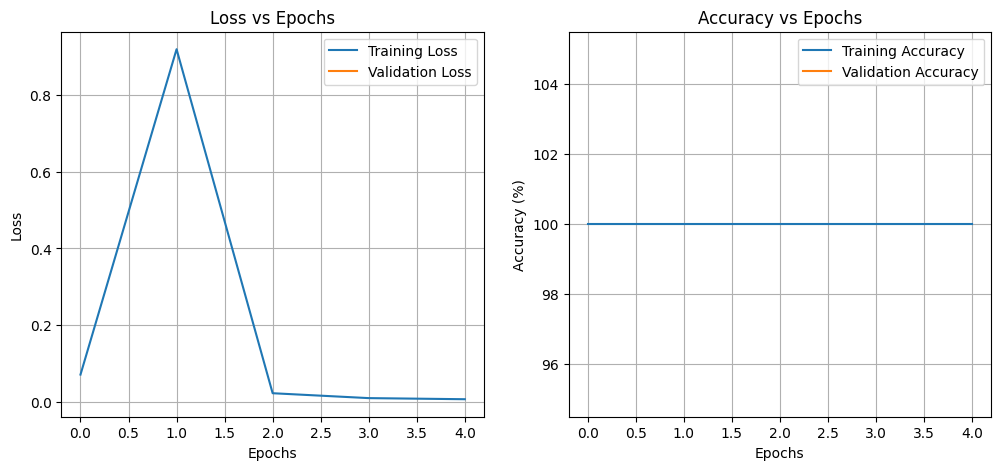

In [31]:
# Print out the model summary
print("Model summary:")
print(model)

# Plot the training and validation losses and accuracies
plt.figure(figsize=(12, 5))

# Plot training and validation losses
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Loss vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()

# Plot training and validation accuracies
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.title('Accuracy vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid()
plt.show()


# Confusion Matrix and Stats

Class weights:
{2: 0.9753919860627178, 0: 0.9953333333333333, 3: 1.0142663043478262, 1: 1.0161070780399275}
Class weights tensor:
tensor([0.9953, 1.0161, 0.9754, 1.0143], device='cuda:0')
Number of samples in the new DataLoader: 218575
Validation Loss: 0.0262, Validation Accuracy: 99.15%
Classification Report:
                    precision    recall  f1-score   support

Very Mild Dementia       0.97      1.00      0.99     13725
      Non Demented       1.00      0.97      0.99     13444
     Mild Dementia       1.00      0.99      1.00     14006
 Moderate Dementia       1.00      1.00      1.00     13469

          accuracy                           0.99     54644
         macro avg       0.99      0.99      0.99     54644
      weighted avg       0.99      0.99      0.99     54644

Confusion Matrix:
[[13712     9     3     1]
 [  310 13069    46    19]
 [   74     3 13927     2]
 [    0     0     0 13469]]


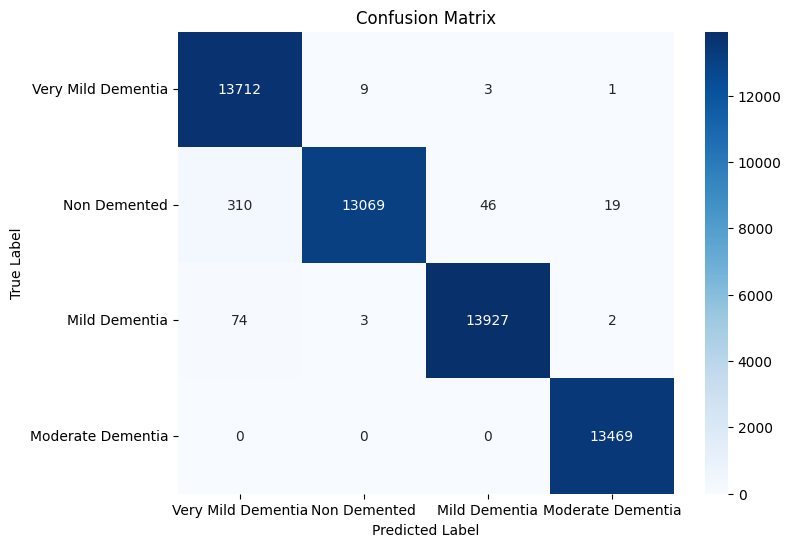

AxisError: axis 1 is out of bounds for array of dimension 1

In [ ]:
# Define a function to evaluate the model
def evaluate_model(model, val_loader):
    model.eval()  # Set the model to evaluation mode
    val_loss = 0.0
    correct = 0
    total = 0
    all_labels = []
    all_predictions = []
    
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())
    
    accuracy = 100 * correct / total
    return val_loss / len(val_loader), accuracy, all_labels, all_predictions

# Evaluate the model on the validation set
val_loss, val_accuracy, all_labels, all_predictions = evaluate_model(model, val_loader)
print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%")

# Calculate ROC AUC score
roc_auc = roc_auc_score(all_labels, all_predictions, multi_class='ovr')
print(f"ROC AUC Score: {roc_auc:.4f}")
# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(all_labels, all_predictions, pos_label=1)
# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label='ROC Curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], 'r--')  # Diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

# Calculate precision-recall curve
precision, recall, _ = precision_recall_curve(all_labels, all_predictions)
# Calculate average precision score
average_precision = average_precision_score(all_labels, all_predictions)
print(f"Average Precision Score: {average_precision:.4f}")
# Plot precision-recall curve
plt.figure(figsize=(8, 6))

plt.plot(recall, precision, label='Precision-Recall Curve (AP = {:.2f})'.format(average_precision))
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower left')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.grid()
plt.show()
# Calculate F1 score
f1 = f1_score(all_labels, all_predictions, average='weighted')
print(f"F1 Score: {f1:.4f}")
# Calculate precision and recall
precision = precision_score(all_labels, all_predictions, average='weighted')
print(f"Precision: {precision:.4f}")
# Calculate recall
recall = recall_score(all_labels, all_predictions, average='weighted')
print(f"Recall: {recall:.4f}")
# Save the model
torch.save(model.state_dict(), 'resnet18_model_final.pth')

# Load the model for inference
model = ResNet18(num_classes=len(oversampled_df['label'].unique())).to(device)

model.load_state_dict(torch.load('resnet18_model_final.pth'))
model.eval()  # Set the model to evaluation mode

# Define a function to make predictions on a single image

def predict_image(model, image_path):
    # Load and preprocess the image
    image = Image.open(image_path).convert('RGB')
    image = transform(image).unsqueeze(0).to(device)  # Add batch dimension and move to device
    
    # Make prediction
    with torch.no_grad():
        output = model(image)
        _, predicted = torch.max(output.data, 1)
    
    return predicted.item()
# Test the prediction function on a sample image
sample_image_path = 'Data/Non Demented/OAS1_0001_MR1_mpr-1_100.jpg'  # Replace with an actual image path
predicted_label = predict_image(model, sample_image_path)
print(f"Predicted label for the sample image: {predicted_label}")
# Print out the label mapping for reference
print("Label mapping for reference:")
print(label_mapping)
# Print out the predicted label in terms of the original labels
predicted_label_original = [k for k, v in label_mapping.items() if v == predicted_label][0]
print(f"Predicted label in terms of original labels: {predicted_label_original}")

# Define a function to make predictions on a batch of images
def predict_batch(model, image_paths):
    model.eval()  # Set the model to evaluation mode
    predictions = []
    
    with torch.no_grad():
        for image_path in image_paths:
            image = Image.open(image_path).convert('RGB')
            image = transform(image).unsqueeze(0).to(device)  # Add batch dimension and move to device
            
            output = model(image)
            _, predicted = torch.max(output.data, 1)
            predictions.append(predicted.item())
    
    return predictions

# Test the batch prediction function on a list of image paths
sample_image_paths = ['Data/Non Demented/OAS1_0001_MR1_mpr-1_100.jpg', 'Data/Very Mild Dementia/OAS1_0002_MR1_mpr-1_100.jpg']  # Replace with actual image paths
predicted_labels = predict_batch(model, sample_image_paths)
print(f"Predicted labels for the sample images: {predicted_labels}")
# Print out the predicted labels in terms of the original labels
predicted_labels_original = [label_mapping[k] for k, v in label_mapping.items() if v in predicted_labels]
print(f"Predicted labels in terms of original labels: {predicted_labels_original}")








# Classification Report and Confusion Matrix


In [ ]:
# Print out the classification report
print("Classification Report:")
print(classification_report(all_labels, all_predictions, target_names=label_mapping.keys()))
# Print out the confusion matrix
conf_matrix = confusion_matrix(all_labels, all_predictions)
print("Confusion Matrix:")
print(conf_matrix)
# Plot the confusion matrix
plt.figure(figsize=(8, 6))

sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_mapping.keys(), yticklabels=label_mapping.keys())
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()